# 1. Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
from nltk.tokenize import wordpunct_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import spacy
from gensim import corpora
import gensim
from sklearn.metrics import f1_score
import gensim.downloader as api
from gensim.models import CoherenceModel
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

import re

from requests import get
from bs4 import BeautifulSoup as bs

import codecs

#Install missing libraries

#!pip install torchtext
!pip install ftfy
#!pip install pyLDAvis
import ftfy
#import pyLDAvis.gensim_models as gensimvis
#import pyLDAvis

from torchtext.data.utils import get_tokenizer
import torch
from torch.utils.data import Dataset, DataLoader
import time
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.5 MB/s 


# 2. Clean the textual data and explore reviews


### 2.1 Opening the file and performing initial analysis
* Open the file
* Clean the unicode texts
* Check the classes distribution
* Check length distrubution of reviews

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Paths
train_data = 'drive/MyDrive/MSC/train.csv'
test_data = 'drive/MyDrive/MSC/test.csv'

In [ ]:
df_reviews=pd.read_csv(train_data,encoding='utf-8',)

In [ ]:
# Defining a function to deal with inconsistent unicode
def unicoderemoval(x):
  s= x.encode("utf-8").decode("unicode_escape")
  t= ftfy.fix_text(s)
  u = t.replace("\n"," ")
  return u

In [ ]:
# Running the function
pd.options.display.max_colwidth = 200
df_reviews["reviews_clean"] = df_reviews["imdb_user_review"].apply(lambda x: unicoderemoval(x))
df_reviews.head()

,helpfulness_cat,imdb_user_review,reviews_clean
0,1.0,"It is hard to find such delightful and adorable movies these days as \""The Kid\"". It is a silent movie but so rich, winning and beautiful that you don\u00b4t nead words. Chaplin and 6-year old Coo...","It is hard to find such delightful and adorable movies these days as ""The Kid"". It is a silent movie but so rich, winning and beautiful that you don´t nead words. Chaplin and 6-year old Coogan are..."
1,1.0,"They don't make films like this faded, haunting masterpiece of silent cinema anymore.When Dracula was first put on sale for movie rights; the one of the first men to grab it was F.W.Murnau one of ...","They don't make films like this faded, haunting masterpiece of silent cinema anymore.When Dracula was first put on sale for movie rights; the one of the first men to grab it was F.W.Murnau one of ..."
2,1.0,"I first viewed this movie in 1924 at age 6 yrs--probably the first movie I ever saw. I thought it was terrific then, and after viewing it again now(2003) I still think it is an exceptionally fine...","I first viewed this movie in 1924 at age 6 yrs--probably the first movie I ever saw. I thought it was terrific then, and after viewing it again now(2003) I still think it is an exceptionally fine..."
3,1.0,"I doubt that I'd ever seen anything resembling a \""complete\"" version of METROPOLIS before, though certain of its scenes were familiar to me, if only as used and abused in such films as Diane Keat...","I doubt that I'd ever seen anything resembling a ""complete"" version of METROPOLIS before, though certain of its scenes were familiar to me, if only as used and abused in such films as Diane Keaton..."
4,1.0,"I was shocked to find myself riveted to this movie. This is without a doubt the best sci-fi movie I've ever seen! Let me explain my position. We have all seen modern sci-fi movies, and argued over...","I was shocked to find myself riveted to this movie. This is without a doubt the best sci-fi movie I've ever seen! Let me explain my position. We have all seen modern sci-fi movies, and argued over..."


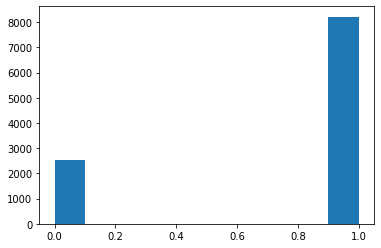

In [ ]:
plt.hist(df_reviews['helpfulness_cat'])
plt.show()

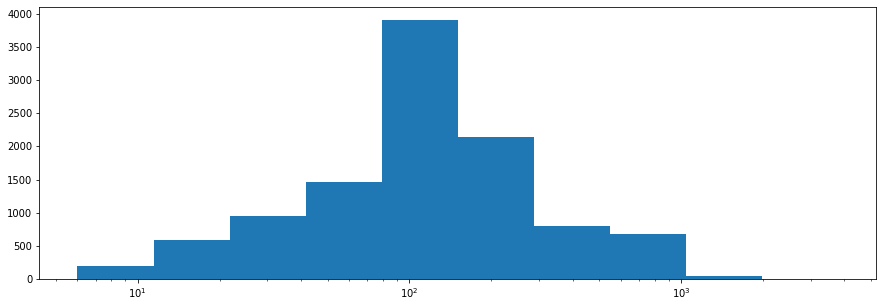

In [ ]:
#check the lenght distribution per review
len_reviews_list=[len(rev.split()) for rev in df_reviews['reviews_clean']]
plt.figure(figsize=(15,5))
x=len_reviews_list
hist, bins = np.histogram(x, bins=10)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.show()

In [ ]:
df_reviews['len_review']=x

In [ ]:
print('Average len of useful reviews is')
print(np.average(df_reviews.loc[df_reviews.helpfulness_cat==1,'len_review']))
print('Average len of unuseful reviews is')
print(np.average(df_reviews.loc[df_reviews.helpfulness_cat==0,'len_review']))

Average len of useful reviews is
187.99963476990504
Average len of unuseful reviews is
134.19756001574183


### 2.2 Display some of helpful and unhelpful reviews

In [ ]:
k=0
for i in df_reviews.loc[df_reviews.helpfulness_cat==0,'reviews_clean']:
    print(i)
    print('NEXT REVIEW')
    k+=1
    if k ==3:
        break

The movie is best described as pathetic. It may be good when people had nothing else, but not today. Not even after sound appeared in films. I wonder what the film is doing so high up in the ratings when it was a galactic effort to even sit through it. Metropolis is a complete waste of time. Ever since dialogues appeared in the films, there is not a single film that is considered good without good dialogues. Take any of the top films, even the IMDb top 250 list. There is not a single film that has won its place with run of the mill dialogues. And this one is without sound. Today's audience wants a story, strong dialogue, good acting and effects. The acting is stiff and out of fashion in Metroplis. The excessive use of expressions to make up for lack of sound may be understandable back then, but today it just looks a bit too funny. My recommendation: Don't watch it!
NEXT REVIEW
Well i was watching this movie for whatever reason. And it was so boring and the people don't even talk in it.

In [ ]:
k=0
for i in df_reviews.loc[df_reviews.helpfulness_cat==1,'reviews_clean']:
    print(i)
    print('NEXT REVIEW')
    k+=1
    if k ==3:
        break

It is hard to find such delightful and adorable movies these days as "The Kid". It is a silent movie but so rich, winning and beautiful that you don´t nead words. Chaplin and 6-year old Coogan are possibly the most charming pair I have ever seen in my life. The film succees to be nicely light and full of joy but also overwhelmingly sad and sentimental. I always get my eyes full with tears of saddness and happiness. And I really never cry in movies. And the music...its simply Oscar-level! The movie is sympathetic, full of feeling, touchingly funny moments. It is truly a masterpiece showing how extraordinary talented person Charlie Chaplin was considering this film is respectively over 80 years old! So don´t you miss it because of it´s age, don´t miss it.
NEXT REVIEW
They don't make films like this faded, haunting masterpiece of silent cinema anymore.When Dracula was first put on sale for movie rights; the one of the first men to grab it was F.W.Murnau one of the most of the famous Germa

## 2.3 Visualising a Scattertext diagram 
This diagram shows words most used associated with the helpful and unhelpful review categories. This is an interactive visualisation

In [ ]:
!pip install scattertext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.3 MB 3.7 MB/s 
     |████████████████████████████████| 24.1 MB 1.3 MB/s 
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9309 sha256=4d9edf7b3499cdc10c2beadc673b0b0f27a4ca29c7ee008eafa9c94ec1743ebf
  Stored in directory: /root/.cache/pip/wheels/cb/19/58/4e8fdd0009a7f89dbce3c18fff2e0d0fa201d5cdfd16f113b7
Successfully built flashtext
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import scattertext as st
import spacy
nlp = spacy.load('en_core_web_sm')
from pprint import pprint

In [ ]:
df = df_reviews.iloc[: , [0, 1]].copy()

In [ ]:
df["Cat"] = df["helpfulness_cat"].apply(lambda x: str(x))
df

,helpfulness_cat,imdb_user_review,Cat
0,1.0,"It is hard to find such delightful and adorable movies these days as \""The Kid\"". It is a silent movie but so rich, winning and beautiful that you don\u00b4t nead words. Chaplin and 6-year old Coo...",1.0
1,1.0,"They don't make films like this faded, haunting masterpiece of silent cinema anymore.When Dracula was first put on sale for movie rights; the one of the first men to grab it was F.W.Murnau one of ...",1.0
2,1.0,"I first viewed this movie in 1924 at age 6 yrs--probably the first movie I ever saw. I thought it was terrific then, and after viewing it again now(2003) I still think it is an exceptionally fine...",1.0
3,1.0,"I doubt that I'd ever seen anything resembling a \""complete\"" version of METROPOLIS before, though certain of its scenes were familiar to me, if only as used and abused in such films as Diane Keat...",1.0
4,1.0,"I was shocked to find myself riveted to this movie. This is without a doubt the best sci-fi movie I've ever seen! Let me explain my position. We have all seen modern sci-fi movies, and argued over...",1.0
...,...,...,...
10750,0.0,"The makers of this movie really touched a sore spot in the grumpy old mans mind, namely the semioffficiaal corrupt system of professional legal guardianship in the united states of america, wher t...",0.0
10751,0.0,"I Care A Lot is an exhilarating black comedy with a head-turning performance from Rosamund Pike. If I had to, I would pay 10 dollars for a ticket to see this in the theaters. Also, expect the unex...",0.0
10752,0.0,Really loved this. This film is masterful in the way it makes you feel about all characters and the message about our westernised systems with plenty of laugh out loud moments.,0.0
10753,0.0,"The story, direction and acting across the board are superb. BUT Peter Dinklage is THE absolute star here IMHO.\nLoved every minute, scene and nuance.",0.0


In [ ]:
# Turn data into a Scattertext Corpus 
corpus = st.CorpusFromPandas(df, 
                              category_col='Cat', 
                              text_col='imdb_user_review',
                              nlp=nlp).build()

In [ ]:
# Checking the most frequent words/phrases for helpful reviews
term_freq_df = corpus.get_term_freq_df()
term_freq_df['Helpful Score'] = corpus.get_scaled_f_scores('1.0')
pprint(list(term_freq_df.sort_values(by='Helpful Score', ascending=False).index[:10]))

/usr/local/lib/python3.7/dist-packages/scattertext/termscoring/ScaledFScore.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.zeros(len(cat_scores)).astype(np.float)


['performance',
 'gives',
 'perfect',
 'wonderful',
 'beautiful',
 'role',
 'brilliant',
 'and his',
 'of his',
 'excellent']


In [ ]:
# Checking the most frequent words/phrases for unhelpful reviews
term_freq_df['Unhelpful Score'] = corpus.get_scaled_f_scores('0.0')
pprint(list(term_freq_df.sort_values(by='Unhelpful Score', ascending=False).index[:10]))

/usr/local/lib/python3.7/dist-packages/scattertext/termscoring/ScaledFScore.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.zeros(len(cat_scores)).astype(np.float)


['bella',
 'twilight',
 'edward',
 'vampires',
 'boring',
 'vampire',
 'waste',
 'waste of',
 'oldboy',
 'horrible']


In [ ]:
html = st.produce_scattertext_explorer(corpus,
...          category='1.0',
...          category_name='Helpful Reviews',
...          not_category_name='Unhelpful Reviews',
...          width_in_pixels=1000)

In [ ]:
open("Convention-Visualization.html", 'wb').write(html.encode('utf-8'))

15343900

## 2.4 Cleaning data

### Step 1: Evaluating whether to remove foreign language rows
We decided not to, since some more poorly formatted reviews (generally classified as unhelpful) were getting misclassified as non-English, which could skew our results

In [ ]:
!pip install langid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 3.9 MB/s 
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941188 sha256=b04e5e02d58a5dbb46762630d7c8a91a92e709b70a13fa4b11df10db9b3882f1
  Stored in directory: /root/.cache/pip/wheels/2b/bb/7f/11e4db39477278161e882eadc46fb558949a28b13470fc74b8
Successfully built langid


In [ ]:
# Identifying rows which are not in English

import langid
# Defining a function
def lng(text):
  a = langid.classify(text)[0]
  return a

df_reviews["imdb_user_review_lang"] = df_reviews["reviews_clean"].apply(lambda x: lng(x))

In [ ]:
import langid
# Defining a function
def lng1(text):
  b = langid.classify(text)[1]
  return b

df_reviews["imdb_user_review_lang_valn"] = df_reviews["reviews_clean"].apply(lambda x: lng1(x))

In [ ]:
pd.options.display.max_colwidth = 50
df_reviews[df_reviews["imdb_user_review_lang"]!='en']

,helpfulness_cat,imdb_user_review,reviews_clean,len_review,imdb_user_review_lang,imdb_user_review_lang_valn
3819,1.0,Sarah ali khan n varun dhawan u morons....\ud8...,Sarah ali khan n varun dhawan u morons....😡😡😡😡...,25,mt,-257.906256
3887,1.0,\ud83d\udd2a\ud83d\udd2a\ud83d\udd2a\ud83d\udd...,🔪🔪🔪🔪🔪 DON'T GIVE YOUR PRECIOUS TIME TO THIS MO...,9,gu,-1.082748
4102,1.0,"Odlican film, istorijski tacan, Odlican film, ...","Odlican film, istorijski tacan, Odlican film, ...",8,bs,-50.347835
4167,1.0,"The best movie ever, i like it a lot. Film je ...","The best movie ever, i like it a lot. Film je ...",21,hr,-239.128387
5131,1.0,If your want to die see the movie \ud83d\udc4e...,If your want to die see the movie 👎🏼👎🏼👎🏼👎🏼👎🏼👎🏼...,9,km,-505.226149
8798,0.0,"Netflix do it again, boring pseudo feminist no...","Netflix do it again, boring pseudo feminist no...",8,pt,-41.686171
8843,1.0,An enjoyable movie going experience. Three che...,An enjoyable movie going experience. Three che...,10,af,-115.578607
9152,1.0,A fun brain candy movie...good action...fun di...,A fun brain candy movie...good action...fun di...,11,eu,-78.615788
9265,0.0,Finally a movie that says the truth \u2764\u27...,Finally a movie that says the truth ❤❤❤❤❤ ❤❤❤❤...,9,mr,-299.976626
9385,1.0,Worst ever super hero movie\ngal gadot cannot ...,Worst ever super hero movie gal gadot cannot a...,13,br,-179.839990


In [ ]:
# Trying another package
!pip install langdetect
from langdetect import detect  

languages = []

for x in range(len(df_reviews["reviews_clean"])):
    languages.append(detect(df_reviews["reviews_clean"][x]))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 3.5 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=d7d8435ed0e2c6114f145586e6d5765e8c96c68b354fff6b21a7478315aa9004
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [ ]:
df_reviews["imdb_user_review_langnew"] = languages

In [ ]:
df_reviews[df_reviews["imdb_user_review_langnew"]!='en']

,helpfulness_cat,imdb_user_review,reviews_clean,len_review,imdb_user_review_lang,imdb_user_review_lang_valn,imdb_user_review_langnew
1992,1.0,HOW DARE YOU DISRESPECT A MOVIE WITH SO MANY I...,HOW DARE YOU DISRESPECT A MOVIE WITH SO MANY I...,16,en,-9.864063,de
3819,1.0,Sarah ali khan n varun dhawan u morons....\ud8...,Sarah ali khan n varun dhawan u morons....😡😡😡😡...,25,mt,-257.906256,id
4102,1.0,"Odlican film, istorijski tacan, Odlican film, ...","Odlican film, istorijski tacan, Odlican film, ...",8,bs,-50.347835,hr
4152,1.0,Great and amazing film.\nSjajan film. Veoma va...,Great and amazing film. Sjajan film. Veoma vaz...,9,en,-66.773998,hr
4167,1.0,"The best movie ever, i like it a lot. Film je ...","The best movie ever, i like it a lot. Film je ...",21,hr,-239.128387,hr
4348,0.0,Very good movie i like it very much make sure ...,Very good movie i like it very much make sure ...,13,en,-88.902386,af
4490,0.0,Complete nonsense. Conspiracy at it's finest. ...,Complete nonsense. Conspiracy at it's finest. ...,7,en,-36.642973,fr
6336,0.0,Hahahaha omg the cgi is awful ahahahahahahaha ...,Hahahaha omg the cgi is awful ahahahahahahaha ...,10,en,-129.955987,so
7591,0.0,"That's very boring , and awful story,,,,,,,,z....","That's very boring , and awful story,,,,,,,,z....",7,en,-47.131999,sk
9331,1.0,Albert Einstein\nIssac Newton\nGalileo Galilei...,Albert Einstein Issac Newton Galileo Galilei S...,23,en,-336.830939,id


In [ ]:
df_reviews = df_reviews.drop(['len_review', 'imdb_user_review_lang', 'imdb_user_review_lang_valn', 'imdb_user_review_langnew' ], axis=1)
df_reviews.head()

,helpfulness_cat,imdb_user_review,reviews_clean
0,1.0,It is hard to find such delightful and adorabl...,It is hard to find such delightful and adorabl...
1,1.0,"They don't make films like this faded, hauntin...","They don't make films like this faded, hauntin..."
2,1.0,I first viewed this movie in 1924 at age 6 yrs...,I first viewed this movie in 1924 at age 6 yrs...
3,1.0,I doubt that I'd ever seen anything resembling...,I doubt that I'd ever seen anything resembling...
4,1.0,I was shocked to find myself riveted to this m...,I was shocked to find myself riveted to this m...


### Step 2: Defining functions to clean aspects of the data

#### 1) Splitting up contractions to full words 
Eg- It's to it is

In [ ]:
!pip install contractions
import contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 4.3 MB/s 
     |████████████████████████████████| 287 kB 29.4 MB/s 


In [ ]:
# Cleaning up contractions
def decontract(x):
  return contractions.fix(x)

#### 2) Removing URLs

In [ ]:
# Looking for strings containing http.// or https.//
def urls(x):
  to_match = ["http\S+",
            "http?://.*?\\s+"]
  text = re.sub('|'.join(to_match), '', x, flags=re.MULTILINE)
  return text

<input>:3: DeprecationWarning: invalid escape sequence \S
<input>:3: DeprecationWarning: invalid escape sequence \S
<input>:3: DeprecationWarning: invalid escape sequence \S
<ipython-input-34-e9520b07ce8f>:3: DeprecationWarning: invalid escape sequence \S
  to_match = ["http\S+",


#### 3) Slang replacement

In [ ]:
# Creating list of links to scrape from Noslang site which is a dictionary of slangs
link1 = 'https://www.noslang.com/dictionary/'
extensions = '1abcdefghijklmnopqrstuvwxyz'

link_list=[]
for i in extensions:
  a = link1+i
  link_list.append(a)

In [ ]:
# Scraping the webpages
headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:79.0) Gecko/20100101 Firefox/79.0'}
allpg = []
for i in link_list:
    url = i
    response = get(url, headers=headers)
    html_soup = bs(response.text, 'html.parser')
    allpg.append(html_soup)

In [ ]:
# Selecting the slangs
slangs = {}
for i in allpg:
    for j in i.findAll('div', {'class':'dictonary-word'}):
      title = j.find('a') ['name']
      abbr = j.find('abbr')['title']
      slangs.update({title : abbr})

for i in list(slangs.items())[200:220]:
  print(i)

('afaicr4', 'as far as i can remember for')
('afaics', 'as far as I can see')
('afaict', 'as far as I can tell')
('afaik', 'as far as I know')
('afair', 'as far as I recall')
('afaiu', 'As far as I understand')
('afc', 'away from computer')
('afcpmgo', 'away from computer parents may go on')
('afg', 'away from game')
('afk', 'away from keyboard')
('afkb', 'away from keyboard')
('agn', 'again')
('ah', 'ass hole')
('ahole', 'a**h**e')
('ai', 'Artificial Intelligence')
('aiadw', 'ALL IN A DAYS WORK')
('aiamu', "and I'm a monkey's uncle")
('aicmfp', 'and I claim my five pounds')
('aight', 'Alright')
('aightz', 'alright')


In [ ]:
# Checking for any 1 letter slang words/slang words that are real words so we don't accidentally replace anything that's not slang
# 1- 1 letter slangs
one_let = [i for i in slangs.keys() if len(i)==1]
print(one_let)

# 2- Checking if any of the words are real. If yes, checking if they need to be removed/replaced
import nltk
nltk.download('words')
from nltk.corpus import words
setofwords = set(words.words())

words_real = [i for i in slangs if i in setofwords]
print(words_real)

dictsm = {}
for i in range(len(words_real)):
    dictsm.update({words_real[i]:[slangs[x] for x in words_real][i]} )
print(dictsm)

# Replacing few words from above logic
slangs.pop('chronic')
slangs.pop('dos')
slangs.pop('hijack')
slangs.pop('tomorrow')
slangs.pop('2')
slangs.pop('4')

['2', '4', '@', 'c', 'k', 'm', 'n', 'o', 'r', 'u', 'y']


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


['ah', 'ai', 'aim', 'aka', 'alright', 'ama', 'Amos', 'anon', 'apod', 'ar', 'arse', 'ase', 'aslop', 'atop', 'bae', 'bah', 'beech', 'bibi', 'bion', 'biz', 'bo', 'bogo', 'bord', 'bout', 'bur', 'c', 'cam', 'cawk', 'char', 'chronic', 'chut', 'cig', 'cob', 'cod', 'col', 'coo', 'cos', 'coz', 'crunk', 'cubi', 'cud', 'curn', 'cwm', 'da', 'dah', 'dey', 'dick', 'din', 'dirl', 'dis', 'dit', 'dob', 'dod', 'don', 'dont', 'dos', 'dum', 'dun', 'dupe', 'em', 'ere', 'eta', 'ey', 'fam', 'fe', 'feat', 'feck', 'fi', 'fifo', 'flamer', 'fob', 'foo', 'fu', 'fub', 'fud', 'fut', 'ga', 'gaj', 'gal', 'gaw', 'gey', 'gim', 'goi', 'gol', 'grog', 'gud', 'gurl', 'guru', 'hak', 'han', 'hau', 'hijack', 'ho', 'homey', 'homo', 'hubby', 'hud', 'huggle', 'idly', 'imu', 'iso', 'iyo', 'k', 'ka', 'kay', 'kit', 'ko', 'kos', 'lak', 'lam', 'lan', 'lat', 'lata', 'leet', 'legit', 'lifo', 'ligas', 'lim', 'lof', 'luff', 'lug', 'lulab', 'lurker', 'ly', 'm', 'mao', 'mho', 'min', 'mir', 'mite', 'mor', 'moro', 'moss', 'mu', 'n', 'na', 'n

'for'

In [ ]:
# Defining a function to replace slangs
def slang_words(text):
    text = ' '.join([slangs.get(i,i) for i in text.split()])
    return text

### Step 3: Creating a function to do all the cleaning, and running it

In [ ]:
# Function
def datacleaning(x):
  x = x.lower()
  x = x.replace('´',"")
  x = decontract(x)
  x = urls(x)
  x = slang_words(x)
  x = re.sub(r'[^\w\s]', '', x)
  return x

In [ ]:
# Running the cleaning process
df_reviews["reviews_clean"] = df_reviews["reviews_clean"].apply(lambda x: datacleaning(x))
pd.options.display.max_colwidth = 200
df_reviews.head()

,helpfulness_cat,imdb_user_review,reviews_clean
0,1.0,"It is hard to find such delightful and adorable movies these days as \""The Kid\"". It is a silent movie but so rich, winning and beautiful that you don\u00b4t nead words. Chaplin and 6-year old Coo...",it is hard to find such delightful and adorable movies these days as the kid it is a silent movie but so rich winning and beautiful that you do not nead words chaplin and 6year old coogan are poss...
1,1.0,"They don't make films like this faded, haunting masterpiece of silent cinema anymore.When Dracula was first put on sale for movie rights; the one of the first men to grab it was F.W.Murnau one of ...",they do not make films like this faded haunting masterpiece of silent cinema anymorewhen dracula was first put on sale for movie rights the one of the first men to grab it was fwmurnau one of the ...
2,1.0,"I first viewed this movie in 1924 at age 6 yrs--probably the first movie I ever saw. I thought it was terrific then, and after viewing it again now(2003) I still think it is an exceptionally fine...",i first viewed this movie in 1924 at age 6 yrsprobably the first movie i ever saw i thought it was terrific then and after viewing it again now2003 i still think it is an exceptionally fine movie ...
3,1.0,"I doubt that I'd ever seen anything resembling a \""complete\"" version of METROPOLIS before, though certain of its scenes were familiar to me, if only as used and abused in such films as Diane Keat...",i doubt that i would ever seen anything resembling a complete version of metropolis before though certain of its scenes were familiar to me if only as used and abused in such films as diane keaton...
4,1.0,"I was shocked to find myself riveted to this movie. This is without a doubt the best sci-fi movie I've ever seen! Let me explain my position. We have all seen modern sci-fi movies, and argued over...",i was shocked to find myself riveted to this movie this is without a doubt the best scifi movie i have ever seen let me explain my position we have all seen modern scifi movies and argued over whi...


## 2.5 Visualising similarity of items classified as helpful and unhelpful

In [ ]:
# Step 1- Splitting data to train-test
train, test = train_test_split(df_reviews, test_size=0.5, random_state=42)

In [ ]:
# Step 2- (1) Doc2Vec modelling: Tokenizing the articles and storing them in a list
tkn_quotes = [wordpunct_tokenize(quote.lower()) for quote in train["reviews_clean"]] 
tgd_quotes = [TaggedDocument(d, [i]) for i, d in enumerate(tkn_quotes)] 

In [ ]:
# Step 2- (2) Running the Doc2Vec model
model = Doc2Vec(
        tgd_quotes, vector_size=20, window=2, min_count=1, workers=4, epochs=100)
model.save("quote_embedding.model")
model = Doc2Vec.load("quote_embedding.model")

In [ ]:
# Step 2- (3) For each of the test documents, retrieving most similar document
inferred_vectors = []
tkn_quotes1 = [wordpunct_tokenize(quote.lower()) for quote in test["reviews_clean"]] 
for i in tkn_quotes1:
  v1 = model.infer_vector(i)
  inferred_vectors.append(v1)

In [ ]:
# Step 2- (4) Converting to a dataframe
inferred_vectors_df = pd.DataFrame(inferred_vectors)
inferred_vectors_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.247469,-0.180134,-0.229946,-0.611609,-0.275779,0.112298,1.129198,0.262561,1.071896,0.889572,-1.730346,1.396811,-1.609798,-1.058972,-0.535566,3.594897,-0.839244,-1.474938,0.017007,-2.276265
1,0.694537,0.407601,0.184554,-0.442458,-0.932213,-0.489336,0.646730,-1.788073,0.253727,0.415946,0.726573,1.785896,-0.023968,-2.842075,0.470695,1.782314,2.301076,-2.094283,-0.614423,-1.126409
2,-0.375806,-0.627245,0.134382,3.948321,-0.078158,-0.881517,-1.589320,2.441573,-0.123849,-0.958821,-0.984414,3.007344,0.337775,-2.316378,-0.507108,2.808970,4.165591,-0.488247,-0.500836,-2.015362
3,-0.664103,0.696402,-2.413806,0.871140,-0.194502,2.184351,0.328963,-1.662486,1.295628,-1.531772,0.075926,3.263682,-1.340128,-2.463036,1.062065,3.531630,0.600726,-1.744627,-0.167427,0.014745
4,-0.021593,-1.047626,0.018786,0.426711,0.913319,-1.052881,-0.018104,-1.611532,-0.360593,-2.458270,-0.272210,2.779272,1.249830,-0.747383,0.171139,1.566171,2.803674,-2.539784,-1.109939,-2.431795


In [ ]:
# Step 2- (5) Reducing dimensions to 2 using Multidimensional scaling
from sklearn.manifold import MDS
embedding = MDS(n_components=2, random_state=5)
inferred_vectors_df_transformed = embedding.fit_transform(inferred_vectors_df)
inferred_vectors_df_transformed.shape

KeyboardInterrupt: ignored

In [ ]:
# Step 2- (6) Converting the above to a dataframe and adding outlet and topic details
inferred_vectors_df1 = pd.DataFrame(inferred_vectors_df_transformed)
inferred_vectors_df1["cat"]= test["helpfulness_cat"].values
inferred_vectors_df1.columns = ["x", "y", "cat"]
inferred_vectors_df1.head()

In [ ]:
# Step 3- Visualising the similarities
import plotly.express as px

fig = px.scatter(inferred_vectors_df1, x="x", y="y", color="cat", title="Review similarity", )

fig.update_traces(opacity=0.6)

fig.update_layout(
    autosize=False,
    width=700,
    height=700,)

fig.update_layout(
    xaxis_title="Dimension 1", yaxis_title="Dimension 2")

fig.show()

# 3. Applying different tokenization and vectorization techniques to use obtained vectors as inputs for predicting useful / unuseful labels using Logistic Regression

### 3.1 Defining functions for text tokenization and vectorization
* tokenize_wordpunkt
* vectorize_docs



In [ ]:
#Function to tokenize sentences using spacy with lemmas
nlp = spacy.load("en_core_web_sm")
def tokenize_spacy_lemma(df_text,string=True): 
    #string allows us to generate either list of tokens or tokenized string
    #tokenized string is used for TF IDF sklearn vectorization
    docs_tokens, tmp_tokens,docs_tokens_str = [], [],[]
    for item in df_text:
        tmp_tokens = [
            token.lemma_
            for token in nlp(item)
            if not token.is_stop and not token.is_punct and not token.like_num
        ]
        docs_tokens.append(tmp_tokens)
        tmp_tokens = []
    if string == True:
        for k in range(len(docs_tokens)):
            joint=' '.join([" ".join(list([str(i) for i in docs_tokens[k] ]))])
            docs_tokens_str.append(joint)
        return docs_tokens_str
    else:
        return docs_tokens

In [ ]:
#Tokenize using NLTK
#very fast, but no lemmas
def tokenize_wordpunkt(df_text,string=True):
    tkn_reviews = [wordpunct_tokenize(rev.lower()) for rev in df_text] 
    if string==True:
      list_docs_str=[]
      for k in range(len(tkn_reviews)):
          joint=' '.join([" ".join(list([str(i) for i in tkn_reviews[k] ]))])
          list_docs_str.append(joint)
      return list_docs_str
    else:
      return tkn_reviews

In [ ]:
#Function to vectorize docs using sklear
def vectorize_docs(x_train,x_test,sklearn_vectorizer):
    vectorized_docs_train=sklearn_vectorizer.fit_transform(x_train)
    vectorized_docs_test=sklearn_vectorizer.transform(x_test)
    return (vectorized_docs_train,vectorized_docs_test)

### 3.2 Model 1: Running Logistic Regression with TF IDF features as inputs

In [ ]:
#Split to test and training to  
#nltk or spacy vectorication - comment or uncomment

x_nltk=tokenize_wordpunkt(df_reviews.reviews_clean)
#x_spacy=tokenize_spacy_lemma(df_reviews.reviews_clean)
y=df_reviews.helpfulness_cat
x_train, x_test, y_train, y_test = train_test_split(x_nltk, 
                                                    #x_spacy,
                                                    y, 
                                                    stratify=y,
                                                    test_size=0.20, 
                                                    random_state=0) 

In [ ]:
#Lets vectorize out datasets and fit Log Regression
#after splitting train and test datasets
vectorized_test_and_train_sets=vectorize_docs(x_train,
               x_test,
               TfidfVectorizer(max_features=100))

x_train_vec=vectorized_test_and_train_sets[0]
x_test_vec=vectorized_test_and_train_sets[1]

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train_vec, y_train)

y_pred=logisticRegr.predict(x_test_vec)
score = f1_score(y_pred, y_test)
score

In [ ]:
#Check overfitting
print(logisticRegr.score(x_train_vec, y_train))
print(logisticRegr.score(x_test_vec, y_test))

What F1 score will we obtain on the test set if we predict all reviews as 1 ('useful')? We can use this score as an indicator of usefullness of the classification model.

In [ ]:
naive_score = f1_score(np.repeat(1,len(y_test)), y_test)
naive_score

* Lemma Spacy tokenization did not affect the f1_score although it took much more time to perform tokenization
* There is no overfit (train and test accuracy score is the same.)
* Naive '1' label assignment is performing better than the trained model. If we assign 1 to each review in the test set – the resulting f1 score is 86.6

#### Tune the number of max_features parameter for TF IDF vectorization

In [ ]:
#Let's play with tuning the max features
def tune_max_features(range_):
    scores=[]
    for i in range_:
        vectorized_test_and_train_sets=vectorize_docs(x_train,
                   x_test,
                   TfidfVectorizer(max_features=i))
        x_train_vec=vectorized_test_and_train_sets[0]
        x_test_vec=vectorized_test_and_train_sets[1]
        logisticRegr = LogisticRegression()
        logisticRegr.fit(x_train_vec, y_train)
        y_pred=logisticRegr.predict(x_test_vec)
        score = f1_score(y_pred, y_test)
        scores.append(score)
    return (scores)

In [ ]:
tune_max_features([100,500,1000,3000,10000])

* With the substantial increase of the number of features the f1 accuracy increases very slightly (less then 1% per step) , but using 3000 features with only 5000 sententes can result in overfit.

## 3.3 Model 2: Topic modelling vectorization

1.   Tokenize text extracting lemmas from words to improve the 'readability' of topics 
2.   Perform LDA vectorization
3. Visualize individual topics

In [ ]:
#Split train and test for spacy 
#to perform spacy tokenization
x_spacy=tokenize_spacy_lemma(df_reviews.reviews_clean,string=False)

y=df_reviews.helpfulness_cat
x_train, x_test, y_train, y_test = train_test_split(x_spacy, 
                                                    y, 
                                                    stratify=y,
                                                    test_size=0.20, 
                                                    random_state=0)    

In [ ]:
#Function to vectorize docs (reviews) using LDA topic modelling
def LDA_vectorization_and_log_reg(train_tokenized_docs,test_tokenized_docs,
                     n_topics,
                     n_passes=15):
    dictionary = corpora.Dictionary(train_tokenized_docs)
    corpus_train = [dictionary.doc2bow(text) for text in train_tokenized_docs]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus_train,
                                                 num_topics = n_topics,
                                                 id2word=dictionary,
                                                 passes=n_passes)
    lda_vecs_train = []
    for i in range(len(corpus_train)):
        top_topics = ldamodel.get_document_topics(corpus_train[i], minimum_probability=0.0)
        topic_vec = [top_topics[i][1] for i in range(n_topics)]
        lda_vecs_train.append(topic_vec)
    corpus_test = [dictionary.doc2bow(text) for text in test_tokenized_docs]
    lda_vecs_test = []
    for i in range(len(corpus_test)):
        top_topics = ldamodel.get_document_topics(corpus_test[i], minimum_probability=0.0)
        topic_vec = [top_topics[i][1] for i in range(n_topics)]
        lda_vecs_test.append(topic_vec)   
    logisticRegr = LogisticRegression()
    logisticRegr.fit(lda_vecs_train, y_train)
    y_pred=logisticRegr.predict(lda_vecs_test)
    score = f1_score(y_pred, y_test)
    viz = gensimvis.prepare(ldamodel, corpus_train, dictionary)
    return {'score':score,
            'viz':viz,
            'model':ldamodel,
            'dictionary':dictionary,
            'corpus':corpus_train}
        

In [ ]:
results_LDA=LDA_vectorization_and_log_reg(x_train,
                              x_test,
                              n_topics=30,
                              n_passes=20)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
print(results_LDA['score'])

0.8636726016476216


In [ ]:
coherence_model_lda = CoherenceModel(

   model=results_LDA['model'], texts=x_train, dictionary=results_LDA['dictionary'], coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5467063115439466


The coherence score improved here from earlier (with uncleaned reviews)

In [ ]:
#Let's visualize produced topic
pyLDAvis.enable_notebook()
results_LDA['viz']

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.409678  0.047695       1        1  21.663411
19     0.438507 -0.000442       2        1  18.833525
21     0.382477  0.158380       3        1  17.700234
27     0.339613  0.119737       4        1  13.360438
12     0.377109  0.026286       5        1  13.309551
1      0.308039 -0.129423       6        1   5.105922
11     0.221305 -0.252829       7        1   2.418567
24     0.030465 -0.180569       8        1   0.972996
5     -0.072110  0.019958       9        1   0.691209
22    -0.072970 -0.006732      10        1   0.637847
13    -0.065835 -0.077992      11        1   0.614528
20    -0.092276  0.029724      12        1   0.487841
17    -0.097954  0.022030      13        1   0.456348
6     -0.102075 -0.029179      14        1   0.436606
25    -0.100237  0.012312      15        1   0.436079
10    -0.108426  0.007163      16        1   0.397390
23    -0.102471  0.041419      17        1   0.282405
16    -0.123658  0.017452      18        1   0.249429
2     -0.122371  0.010907      19        1   0.247982
0     -0.128201  0.015361      20        1   0.221399
15    -0.121903  0.003438      21        1   0.213794
26    -0.130340  0.014353      22        1   0.202897
7     -0.130064  0.016890      23        1   0.202652
9     -0.130197  0.019834      24        1   0.171693
4     -0.132695  0.016479      25        1   0.159708
18    -0.133592  0.016093      26        1   0.145078
28    -0.134730  0.015840      27        1   0.115958
3     -0.135028  0.015639      28        1   0.102338
29    -0.135107  0.014823      29        1   0.088832
14    -0.134954  0.015351      30        1   0.073342, topic_info=         Term          Freq         Total Category  logprob  loglift
62      movie  17421.000000  17421.000000  Default  30.0000  30.0000
18       film  13093.000000  13093.000000  Default  29.0000  29.0000
988      book    870.000000    870.000000  Default  28.0000  28.0000
283    action   1336.000000   1336.000000  Default  27.0000  27.0000
686      star   1022.000000   1022.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
124   fivethe      0.009126      0.705847  Topic30 -10.8920   2.8695
125   fleeing      0.009126      0.705847  Topic30 -10.8920   2.8695
4977   gender      0.148792     51.571076  Topic30  -8.1006   1.3696
261    switch      0.009126     71.033945  Topic30 -10.8920  -1.7420
5172   reboot      0.009126     32.541247  Topic30 -10.8920  -0.9614

[1515 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
0          1  0.129446          
0          2  0.257158          
0          3  0.030435          
0          4  0.527799          
0          5  0.049698          
...      ...       ...       ...
13494     30  0.708063   zambian
13075     18  0.980004  zemeckis
3530       1  0.289227    zombie
3530       4  0.706382    zombie
13495     30  0.714097      zulu

[2753 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 20, 22, 28, 13, 2, 12, 25, 6, 23, 14, 21, 18, 7, 26, 11, 24, 17, 3, 1, 16, 27, 8, 10, 5, 19, 29, 4, 30, 15])

## 3.4 Model 3: Word2vec vectorization using pre-trained model with 25 features 


In [ ]:
#model = api.load("glove-twitter-50")
#applying larger (size 50) model did not improve f1 score
model_25 = api.load("glove-twitter-25")

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
#A function to vectorize reviews by summing W2V vectors of words
def embedding_twitter(df_text,model):
    tkn_reviews = [wordpunct_tokenize(rev.lower()) for rev in df_text] 
    vectors =[]
    out=0
    in_=0
    for rev in tkn_reviews:
      vector=np.zeros(25)
      in_this = 0
      for tkn in rev: 
        try:
          in_+=1
          in_this+=1
          vector+=model[tkn]
        except:
          out+=1
          continue
      vectors.append(vector / max(in_this,1))
    print('out of voc',out)
    print('in voc',in_)
    return vectors

In [ ]:
df_reviews

,helpfulness_cat,imdb_user_review,reviews_clean
0,1.0,"It is hard to find such delightful and adorable movies these days as \""The Kid\"". It is a silent movie but so rich, winning and beautiful that you don\u00b4t nead words. Chaplin and 6-year old Coo...",it is hard to find such delightful and adorable movies these days as the kid it is a silent movie but so rich winning and beautiful that you do not nead words chaplin and 6year old coogan are poss...
1,1.0,"They don't make films like this faded, haunting masterpiece of silent cinema anymore.When Dracula was first put on sale for movie rights; the one of the first men to grab it was F.W.Murnau one of ...",they do not make films like this faded haunting masterpiece of silent cinema anymorewhen dracula was first put on sale for movie rights the one of the first men to grab it was fwmurnau one of the ...
2,1.0,"I first viewed this movie in 1924 at age 6 yrs--probably the first movie I ever saw. I thought it was terrific then, and after viewing it again now(2003) I still think it is an exceptionally fine...",i first viewed this movie in 1924 at age 6 yrsprobably the first movie i ever saw i thought it was terrific then and after viewing it again now2003 i still think it is an exceptionally fine movie ...
3,1.0,"I doubt that I'd ever seen anything resembling a \""complete\"" version of METROPOLIS before, though certain of its scenes were familiar to me, if only as used and abused in such films as Diane Keat...",i doubt that i would ever seen anything resembling a complete version of metropolis before though certain of its scenes were familiar to me if only as used and abused in such films as diane keaton...
4,1.0,"I was shocked to find myself riveted to this movie. This is without a doubt the best sci-fi movie I've ever seen! Let me explain my position. We have all seen modern sci-fi movies, and argued over...",i was shocked to find myself riveted to this movie this is without a doubt the best scifi movie i have ever seen let me explain my position we have all seen modern scifi movies and argued over whi...
...,...,...,...
10750,0.0,"The makers of this movie really touched a sore spot in the grumpy old mans mind, namely the semioffficiaal corrupt system of professional legal guardianship in the united states of america, wher t...",the makers of this movie really touched a sore spot in the grumpy old mans mind namely the semioffficiaal corrupt system of professional legal guardianship in the united states of america wher the...
10751,0.0,"I Care A Lot is an exhilarating black comedy with a head-turning performance from Rosamund Pike. If I had to, I would pay 10 dollars for a ticket to see this in the theaters. Also, expect the unex...",i care a lot is an exhilarating black comedy with a headturning performance from rosamund pike if i had to i would pay 10 dollars for a ticket to see this in the theaters also expect the unexpecte...
10752,0.0,Really loved this. This film is masterful in the way it makes you feel about all characters and the message about our westernised systems with plenty of laugh out loud moments.,really loved this this film is masterful in the way it makes you feel about all characters and the message about our westernised systems with plenty of laugh out loud moments
10753,0.0,"The story, direction and acting across the board are superb. BUT Peter Dinklage is THE absolute star here IMHO.\nLoved every minute, scene and nuance.",the story direction and acting across the board are superb but peter dinklage is the absolute star here imho loved every minute scene and nuance


In [ ]:
#Split to test and training to  
#nltk vectorication
x=df_reviews.reviews_clean
y=df_reviews.helpfulness_cat
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, stratify =y,
                                                    test_size=0.20, 
                                                    random_state=0)          

In [ ]:
#Check if the stratification worked fine (divided each subset with proportional number of classes)
print(np.average(y_test))
print (np.average(y_train))

0.7638307763830776
0.7637145513714552


In [ ]:
test_vecs=embedding_twitter(x_test,model_25)
train_vecs=embedding_twitter(x_train,model_25)

out of voc 9213
in voc 380985
out of voc 36472
in voc 1526928


In [ ]:
logisticRegr = LogisticRegression()
logisticRegr.fit(train_vecs, y_train)
y_pred=logisticRegr.predict(test_vecs)
score = f1_score(y_pred, y_test)
score

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8613490364025694

In [ ]:
#Check overfitting
print(logisticRegr.score(train_vecs, y_train))
print(logisticRegr.score(test_vecs, y_test))

0.7645281264528127
0.7591817759181776


# 4. Deep learning models

## 4.1 KERAS

### DL Model 1: TF-DF vectorization approach as an input for our Keras NN

In [ ]:
#create train,test,val from tokenized nltk df
y=df_reviews.helpfulness_cat
x=x_nltk
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    stratify=y,
                                                    test_size=0.20, 
                                                    random_state=0)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    stratify=y_train,
                                                    test_size=0.10, 
                                                    random_state=0) 

In [ ]:
#retreive vectorized models
tf_idf=TfidfVectorizer(max_features=100)
X_train=tf_idf.fit_transform(x_train)
X_test=tf_idf.transform(x_test)
X_val=tf_idf.transform(x_val)

In [ ]:
#try a simple 4 layers NN
model = Sequential()

model.add(layers.Dense(input_shape = X_train.shape[1:],units=10, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(10, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                1010      
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,241
Trainable params: 1,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train.toarray(), y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_val.toarray(), y_val)
                    ,batch_size=16)
                    
loss, accuracy = model.evaluate(X_train.toarray(), y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test.toarray(), y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/20
484/484 [==============================] - 6s 4ms/step - loss: 0.5575 - accuracy: 0.7575 - val_loss: 0.5400 - val_accuracy: 0.7642
Epoch 2/20
484/484 [==============================] - 2s 3ms/step - loss: 0.5233 - accuracy: 0.7637 - val_loss: 0.5347 - val_accuracy: 0.7642
Epoch 3/20
484/484 [==============================] - 2s 3ms/step - loss: 0.5146 - accuracy: 0.7635 - val_loss: 0.5338 - val_accuracy: 0.7607
Epoch 4/20
484/484 [==============================] - 2s 3ms/step - loss: 0.5100 - accuracy: 0.7662 - val_loss: 0.5324 - val_accuracy: 0.7596
Epoch 5/20
484/484 [==============================] - 2s 3ms/step - loss: 0.5077 - accuracy: 0.7687 - val_loss: 0.5328 - val_accuracy: 0.7491
Epoch 6/20
484/484 [==============================] - 1s 3ms/step - loss: 0.5051 - accuracy: 0.7675 - val_loss: 0.5322 - val_accuracy: 0.7468
Epoch 7/20
484/484 [==============================] - 2s 3ms/step - loss: 0.5029 - accuracy: 0.7706 - val_loss: 0.5373 - val_accuracy: 0.7573
Epoch 

In [ ]:
y_predicted = model.predict(X_test.toarray())
y_predicted_labels=np.where(y_predicted > 0.5, 1,0)
score = f1_score(y_predicted_labels, y_test)
score

0.8501106194690267

### DL Model 2: Pre-trained Word2vec model (gensim twitter 25)  as an input with LSTM layer

#### Some crafted functions to apply pre-trained Gensim Twitter 25 W2V model

In [ ]:
def get_train_vocabulary(train_docs,model):
  voc={}
  idx_=0
  for doc in train_docs:
    for word in doc:
      if word not in voc and word in model.vocab.keys():
        voc[word]=idx_
        idx_+=1
  return voc

In [ ]:
def text_to_seq(docs,vocabulary):
  seq_list=[]
  for sent in docs:
    idx=[]
    for word in sent:
      if word in vocabulary:
        idx.append(vocabulary[word])
      else:
        continue
    seq_list.append(idx)
  return seq_list

#### Split the train dataset, apply custom functions and perform padding

In [ ]:
y=df_reviews.helpfulness_cat
x=df_reviews['imdb_user_review']
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    stratify=y,
                                                    test_size=0.20, 
                                                    random_state=0)      
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    stratify=y_train,
                                                    test_size=0.10, 
                                                    random_state=0) 

In [ ]:
X_train=tokenize_wordpunkt(x_train,string=False)
X_test=tokenize_wordpunkt(x_test,string=False)
X_val=tokenize_wordpunkt(x_val,string=False)

In [ ]:
#get vocabulary
train_voc=get_train_vocabulary(X_train,model_25)

In [ ]:
#aply custom function to get sequences of numbers from sentences
X_train_seq=text_to_seq(X_train,train_voc)
X_test=text_to_seq(X_test,train_voc)
X_val=text_to_seq(X_val,train_voc)

In [ ]:
voc_size = len(train_voc)

In [ ]:
#Perform padding
max_len=300
padded_train = tf.keras.preprocessing.sequence.pad_sequences(
    text_to_seq(X_train,train_voc), padding="post",maxlen=max_len, value=voc_size)
X_test = tf.keras.preprocessing.sequence.pad_sequences(
    text_to_seq(X_test,train_voc), padding="post",maxlen=max_len, value=voc_size)
X_val = tf.keras.preprocessing.sequence.pad_sequences(
    text_to_seq(X_val,train_voc), padding="post",maxlen=max_len, value=voc_size)

In [ ]:
# Creating weights matrix (matching sequences with vector representations from pre-trained model)
EMBEDDING_DIM=25
embedding_matrix = np.zeros((len(train_voc) + 1, EMBEDDING_DIM))
for word, i in train_voc.items():
    embedding_vector = model_25[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

#### Training the model and assessing performance

In [ ]:
model = Sequential()
model.add(layers.Embedding(input_dim=len(train_voc)+1, 
                           output_dim=EMBEDDING_DIM, 
                           weights=[embedding_matrix]
                           ,trainable=False))
model.add(layers.Masking(mask_value=voc_size, input_shape=(max_len,)))
model.add(layers.LSTM(24))
#model.add(layers.Dense(units=vocab_size))
model.add(layers.Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 25)          826375    
                                                                 
 masking (Masking)           (None, None, 25)          0         
                                                                 
 lstm (LSTM)                 (None, 24)                4800      
                                                                 
 dense_4 (Dense)             (None, 1)                 25        
                                                                 
Total params: 831,200
Trainable params: 4,825
Non-trainable params: 826,375
_________________________________________________________________


In [ ]:
history = model.fit(padded_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_val, y_val)
                    ,batch_size=128)

Epoch 1/20
61/61 [==============================] - 8s 40ms/step - loss: 0.6012 - accuracy: 0.7488 - val_loss: 0.5501 - val_accuracy: 0.7642
Epoch 2/20
61/61 [==============================] - 1s 15ms/step - loss: 0.5434 - accuracy: 0.7637 - val_loss: 0.5478 - val_accuracy: 0.7642
Epoch 3/20
61/61 [==============================] - 1s 16ms/step - loss: 0.5429 - accuracy: 0.7637 - val_loss: 0.5464 - val_accuracy: 0.7642
Epoch 4/20
61/61 [==============================] - 1s 15ms/step - loss: 0.5425 - accuracy: 0.7637 - val_loss: 0.5462 - val_accuracy: 0.7642
Epoch 5/20
61/61 [==============================] - 1s 15ms/step - loss: 0.5418 - accuracy: 0.7637 - val_loss: 0.5464 - val_accuracy: 0.7642
Epoch 6/20
61/61 [==============================] - 1s 16ms/step - loss: 0.5413 - accuracy: 0.7637 - val_loss: 0.5464 - val_accuracy: 0.7642
Epoch 7/20
61/61 [==============================] - 1s 15ms/step - loss: 0.5405 - accuracy: 0.7637 - val_loss: 0.5492 - val_accuracy: 0.7642
Epoch 8/20
61

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
accuracy

0.7638307809829712

In [ ]:
y_predicted = model.predict(X_test)
y_predicted_labels=np.where(y_predicted > 0.5, 1,0)
score = f1_score(y_predicted_labels, y_test)
score

0.8661043753294676

### DL Model 3: Applying BERT layers

In [ ]:
y=df_reviews.helpfulness_cat
x=df_reviews.reviews_clean
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    stratify=y,
                                                    test_size=0.20, 
                                                    random_state=0)      
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    stratify=y_train,
                                                    test_size=0.10, 
                                                    random_state=0) 

In [ ]:
import tensorflow_hub as hub
#it may take some while to download
!pip install "tensorflow-text==2.8.*"
import tensorflow_text as text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 3.8 MB/s 


In [ ]:
#retrieve BERT layers
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [ ]:
#lets have a look at how the pre-processing layer works
check_preprocess=bert_preprocess([x_train[0]])
check_preprocess['input_word_ids']

<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[  101,  2009,  2003,  2524,  2000,  2424,  2107, 26380,  1998,
        23677,  5691,  2122,  2420,  2004,  1996,  4845,  2009,  2003,
         1037,  4333,  3185,  2021,  2061,  4138,  3045,  1998,  3376,
         2008,  2017,  2079,  2025, 11265,  4215,  2616, 23331,  1998,
         1020, 29100,  2214,  2522, 21131,  2024,  4298,  1996,  2087,
        11951,  3940,  1045,  2031,  2412,  2464,  1999,  2026,  2166,
         1996,  2143, 10514,  9468, 10285,  2000,  2022, 19957,  2422,
         1998,  2440,  1997,  6569,  2021,  2036, 24783,  6517,  1998,
        23069,  1045,  2467,  2131,  2026,  2159,  2440,  2007,  4000,
         1997,  6517,  2094,  2791,  1998,  8404,  1998,  1045,  2428,
         2196,  5390,  1999,  5691,  1998,  1996,  2189, 12762,  3432,
         7436, 20414,  2884,  1996,  3185,  2003, 13026,  2440,  1997,
         3110,  7244,  2135,  6057,  5312,  2009,  2003,  5621,  1037,
        17743,  4760,  2129, 

In [ ]:
#check how encoder works
check_encoder=bert_encoder(check_preprocess)
check_encoder['sequence_output']

<tf.Tensor: shape=(1, 128, 768), dtype=float32, numpy=
array([[[-0.09483425,  0.02509628,  0.00794085, ..., -0.49546272,
          0.45173013,  0.20836335],
        [ 0.00378387,  0.20399034, -0.28273895, ...,  0.13478795,
          1.3335385 ,  0.38007602],
        [-0.00591481,  0.12706122,  0.15976521, ..., -0.71001875,
          0.41201642,  0.04064867],
        ...,
        [ 0.45924836,  0.13019066, -0.25051722, ..., -0.1414549 ,
          0.21332017, -0.20304096],
        [-0.26811668,  0.00673912, -0.02975496, ...,  0.21424296,
          0.47883397, -0.2404381 ],
        [ 0.4136543 ,  0.37176904,  0.14373316, ..., -0.16149329,
         -0.3951578 , -0.08344617]]], dtype=float32)>

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(np.array(x_train),
          np.array(y_train),
          epochs=2,
          validation_data=(np.array(x_val), y_val),
          batch_size = 32)
y_predicted = model.predict(np.array(x_test))
y_predicted_labels=np.where(y_predicted > 0.5, 1,0)
score = f1_score(y_predicted_labels, y_test)
score

Epoch 1/2
242/242 [==============================] - 3829s 16s/step - loss: 0.5506 - accuracy: 0.7599 - val_loss: 0.5278 - val_accuracy: 0.7642
Epoch 2/2
242/242 [==============================] - 3818s 16s/step - loss: 0.5331 - accuracy: 0.7585 - val_loss: 0.5215 - val_accuracy: 0.7642


0.8658922914466737

Preparing the test set and getting the final prediction

In [ ]:
df_test=pd.read_csv(test_data,encoding='utf-8',)

In [ ]:
# Running the function
pd.options.display.max_colwidth = 200
df_test["reviews_clean"] = df_test["imdb_user_review"].apply(lambda x: unicoderemoval(x))
df_test.head()

,_id,imdb_user_review,reviews_clean
0,610d01fe9a63eb113d2235ac,"This is basically a German takeoff on a Sherlock Holmes story. Now, if told in a competent way, Sherlock Holmes-inspired tales can be entertaining, even if of secondary heritage. But this abominat...","This is basically a German takeoff on a Sherlock Holmes story. Now, if told in a competent way, Sherlock Holmes-inspired tales can be entertaining, even if of secondary heritage. But this abominat..."
1,610d01fe9a63eb113d224536,"In January of 1924, director Erich von Stroheim gathered a small group of friends to view his magnum opus, a film which would become legendary. This was GREED &amp; when the experience was over, a...","In January of 1924, director Erich von Stroheim gathered a small group of friends to view his magnum opus, a film which would become legendary. This was GREED & when the experience was over, all t..."
2,610d01fe9a63eb113d224d14,Silent movies are not for everyone. Neither are subtitles. Those brave enough to view a movie with no sound and words that are far and few between should definitely enjoy this silent masterpiece. ...,Silent movies are not for everyone. Neither are subtitles. Those brave enough to view a movie with no sound and words that are far and few between should definitely enjoy this silent masterpiece. ...
3,610d01fe9a63eb113d225f17,"It so often happens that some films take the long way to achieve their status of classics and worthy of being studied, frame by frame, by movie lovers who believe in the power of raw performance a...","It so often happens that some films take the long way to achieve their status of classics and worthy of being studied, frame by frame, by movie lovers who believe in the power of raw performance a..."
4,610d01fe9a63eb113d225f1a,"I saw this film for the very first time last week and was so tremendously captivated by it that I needed to share this rapture. The innovative camera-angles, the close-ups revealing pain and spiri...","I saw this film for the very first time last week and was so tremendously captivated by it that I needed to share this rapture. The innovative camera-angles, the close-ups revealing pain and spiri..."


In [ ]:
df_test["imdb_user_review_lang"] = df_test["reviews_clean"].apply(lambda x: lng(x))
df_test["imdb_user_review_lang_valn"] = df_test["reviews_clean"].apply(lambda x: lng1(x))
pd.options.display.max_colwidth = 50
df_test[df_test["imdb_user_review_lang"]!='en']



,_id,imdb_user_review,reviews_clean,imdb_user_review_lang,imdb_user_review_lang_valn
510,610d02089a63eb113d2fe99a,"This movie, singlehandedly, saved my marriage....","This movie, singlehandedly, saved my marriage....",it,-1298.407276
1741,610d02169a63eb113d453312,"Worst worst Comedy , NOT ONE TIME WATCH TOO , ...","Worst worst Comedy , NOT ONE TIME WATCH TOO , ...",nl,-29.460060
1766,610d02169a63eb113d456a92,Fake movie h. Kanchana best movie h original. ...,Fake movie h. Kanchana best movie h original. ...,af,-36.975652
3594,610d02219a63eb113d548bd0,KAKAV JE OVO TSHRO OD USRANOG FILMA JEBO VAS H...,KAKAV JE OVO TSHRO OD USRANOG FILMA JEBO VAS H...,rw,-69.382356
4206,610d02249a63eb113d594b34,Mmm mmMM mmmmmmm Mmmmmm. Mmmmmmm Mm m MMM! MMM...,Mmm mmMM mmmmmmm Mmmmmm. Mmmmmmm Mm m MMM! MMM...,mt,-135.474604
4672,610d02259a63eb113d5c2237,South Indian most expected movie kurukshetra D...,South Indian most expected movie kurukshetra D...,id,-212.293078
4951,610d02269a63eb113d5e1bf8,"Best inspired movie 2018\n\""I Never fear Lose ...","Best inspired movie 2018 ""I Never fear Lose bu...",no,-79.404977


In [ ]:
df_test = df_test.drop(['imdb_user_review_lang', 'imdb_user_review_lang_valn', 'imdb_user_review' ], axis=1)
df_test.head()

,_id,reviews_clean
0,610d01fe9a63eb113d2235ac,This is basically a German takeoff on a Sherlo...
1,610d01fe9a63eb113d224536,"In January of 1924, director Erich von Strohei..."
2,610d01fe9a63eb113d224d14,Silent movies are not for everyone. Neither ar...
3,610d01fe9a63eb113d225f17,It so often happens that some films take the l...
4,610d01fe9a63eb113d225f1a,I saw this film for the very first time last w...


In [ ]:
# Running the cleaning process
df_test["reviews_clean"] = df_test["reviews_clean"].apply(lambda x: datacleaning(x))
pd.options.display.max_colwidth = 200
df_test.head()

,_id,reviews_clean
0,610d01fe9a63eb113d2235ac,this is basically a german takeoff on a sherlock holmes story now if told in a competent way sherlock holmesinspired tales can be entertaining even if of secondary heritage but this abomination is...
1,610d01fe9a63eb113d224536,in january of 1924 director erich von stroheim gathered a small group of friends to view his magnum opus a film which would become legendary this was greed when the experience was over all there ...
2,610d01fe9a63eb113d224d14,silent movies are not for everyone neither are subtitles those brave enough to view a movie with no sound and words that are far and few between should definitely enjoy this silent masterpiece one...
3,610d01fe9a63eb113d225f17,it so often happens that some films take the long way to achieve their status of classics and worthy of being studied frame by frame by movie lovers who believe in the power of raw performance and...
4,610d01fe9a63eb113d225f1a,i saw this film for the very first time last week and was so tremendously captivated by it that i needed to share this rapture the innovative cameraangles the closeups revealing pain and spiritual...


In [ ]:
x_final=df_test.reviews_clean

In [ ]:
y_final = model.predict(np.array(x_final))
y_final_labels=np.where(y_final > 0.5, 1,0)



In [ ]:
results =[i[0] for i in y_final_labels]
df_test['Y'] = results

In [ ]:
df_test.head()

,_id,reviews_clean,Y
0,610d01fe9a63eb113d2235ac,this is basically a german takeoff on a sherlock holmes story now if told in a competent way sherlock holmesinspired tales can be entertaining even if of secondary heritage but this abomination is...,1
1,610d01fe9a63eb113d224536,in january of 1924 director erich von stroheim gathered a small group of friends to view his magnum opus a film which would become legendary this was greed when the experience was over all there ...,1
2,610d01fe9a63eb113d224d14,silent movies are not for everyone neither are subtitles those brave enough to view a movie with no sound and words that are far and few between should definitely enjoy this silent masterpiece one...,1
3,610d01fe9a63eb113d225f17,it so often happens that some films take the long way to achieve their status of classics and worthy of being studied frame by frame by movie lovers who believe in the power of raw performance and...,1
4,610d01fe9a63eb113d225f1a,i saw this film for the very first time last week and was so tremendously captivated by it that i needed to share this rapture the innovative cameraangles the closeups revealing pain and spiritual...,1


In [ ]:
df_test.to_csv('/content/drive/MyDrive/MSC/FCP.csv')



## 4.2 Pytorch

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import time
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

In [ ]:
x=df_reviews.imdb_user_review
y=df_reviews.helpfulness_cat
X_train, X_test, Y_train, Y_test = train_test_split(x, 
                                                    y, 
                                                    stratify=y,
                                                    test_size=0.20, 
                                                    random_state=0) 

In [ ]:
class IMDB_helpful_reviews(Dataset):

    def __init__(self,x,y):
        
        self.x = x
        self.y = y
       

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        review = self.x.iloc[idx, ]
        label= self.y.iloc[idx, ]

        #sample = {'label': label, 'review': review}
        sample = (label, review)
        return sample

In [ ]:
train_set=IMDB_helpful_reviews(X_train,Y_train)
test_set=IMDB_helpful_reviews(X_test,Y_test)

In [ ]:
# tokenization
tokenizer = get_tokenizer('basic_english')
#train_iter = train_set
# apply the tokenizer
# --+ custom function
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)
# --+ deploy the tokenizer to get the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_set), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
# tokenize reviews 
text_pipeline = lambda x: vocab(tokenizer(x))
# encode review labels
label_pipeline = lambda x: int(x)

In [ ]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# custom function
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)
# deploy the function
dataloader = DataLoader(train_set, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [ ]:
from torch import nn
# the class associated with the module
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [ ]:
num_class = len(set([label for (label, text) in train_set]))
# vocabulary size
vocab_size = len(vocab)
# ebedding bag size
emsize = 64
# model instantiation
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)


In [ ]:
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

In [ ]:
# custom function for evaluation
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [ ]:
EPOCHS = 10 
# --+ learning rate
LR = 0.01  
# --+ batch size for training
BATCH_SIZE = 64 
# optimization
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
# data handling

train_dataset = to_map_style_dataset(train_set)
test_dataset = to_map_style_dataset(test_set)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])


In [ ]:
train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

In [ ]:
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

-----------------------------------------------------------
| end of epoch   1 | time:  3.96s | valid accuracy    0.738 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time:  1.21s | valid accuracy    0.738 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time:  1.20s | valid accuracy    0.738 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time:  1.19s | valid accuracy    0.738 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time:  1.18s | valid accuracy    0.738 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   6 | time:  1.17s |

In [ ]:
print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

Checking the results of test dataset.
test accuracy    0.764


The accuracy score of 76% does not show any progression comparing to all previously described models

# 5. Further context in classification

In [ ]:
# Evaluating the sentiment for the reviews (unlabelled)
!pip install flair
from flair.models import TextClassifier
from flair.data import Sentence
sia = TextClassifier.load('en-sentiment')

def flair_prediction(x):
  sentence = Sentence(x)
  sia.predict(sentence)
  score = sentence.labels[0]

  if "POSITIVE" in str(score):
    return "pos"

  elif "NEGATIVE" in str(score):
    return "neg"

  else:
    return "neu"

In [ ]:
titanicdf = df_reviews.iloc[1448:(1448+19)]
godfatherdf = df_reviews[386:(386+15)]
df = pd.concat([titanicdf, godfatherdf], ignore_index=True)
df["sentiment"] = df["reviews_clean"].apply(flair_prediction)
# Manual sentiment classification
neg = np.repeat('neg', len(titanicdf["reviews_clean"])-5)
pos = np.repeat('pos', 5)
neg1 = np.repeat('neg', len(godfatherdf["reviews_clean"])-6)
pos1 = np.repeat('pos', 6)
df["sentiment_manual"] = np.concatenate((pos, neg, pos1, neg1))
# Separating movies
ttc = np.repeat('titanic', len(titanicdf))
gft = np.repeat('godfather', len(godfatherdf))
df["Filter"] = np.repeat("Counts", len(df))
df["movie"] = np.concatenate((ttc, gft))
df

In [ ]:
pivot_table = pd.pivot_table(df, 
                             columns='helpfulness_cat', 
                             index=['movie', 'sentiment_manual'],
                             values='Filter',
                             aggfunc='count')
pivot_table = pivot_table.fillna("-")
pivot_table

# 6.  Classification based on our subjective judgement

To understand if our team's judgement could overperform the one obtained by the machine, we classified 80 reviews after reading 20 labeled reviews. Then, we measured the corresponding F1 score for our predictions.

In [ ]:
y_human_test=pd.read_csv('test_human.csv')
y_human_true=pd.read_csv('test_human_labels.csv')
score = f1_score(y_human_test['Your prediction'], y_human_true.helpfulness_cat)
score

The resulting F1 score is 80%. Hence, we couldn't gain a better F1 score than the one produced by NLP models.